# 1. Normalizing Flows

a. Describe the training objective for flows.

asd

b. Describe the sampling process of normalizing flows.

asd

c. What properties does the transformation function $f_\theta$ must satisfy for practical flow models?

# 2. Wasserstein Distance

In many cases, the GAN algorithm can be though of as minimizing a divergence between a data distribution $p_{data}$ and the model distribution $p_g$. In this problem, we will explore an issue with various divergences (e.g., Jensen-Shannon divergence and KL divergence) and one potential way to fix it.

a. Let $p_{data}~\mathcal{N}(\theta_0,\epsilon^2)$ and $p_g~\mathcal{N}(x|\theta,\epsilon^2)$ be normal distributions with standard deviation $\epsilon$ centered at $\theta_0\in\mathbb{R}$ and $\theta\in\mathbb{R}$, respectively. Show that

$$ D_{KL}(p_g||p_{data})=\frac{(\theta-\theta_0)^2}{2\epsilon^2}. $$

b. Suppose $p_data$ and $p_g$ both place probability mass in only a very small part of the domain; that is, consider the limit $\epsilon\rightarrow0$. What happens to $D_{KL}(p_g||p_{data})$ and its derivative with respect to $\theta$, assuming that $\theta\neq\theta_0$?

c. Would this pose an issue for a GAN trained with the loss function defined below? Why?

$$ L_G(\theta;\phi)=\mathbb{E}_{x~p_\theta(x)}[\log(1-D_\phi(x))]-\mathbb{E}_{x~p_\theta(x)}[\log D_\phi(x)] $$

d. Under the same circumstances as (b), compare KL divergence, JS divergence and Wasserstein Distance.

# 3. Wasserstein GAN for MNIST

In this question, you will train a Wasserstein GAN on the MNIST dataset, which comprises $28\times28$ grayscale images.

a. Implement the optimization process for the Wasserstein GAN. Consider making multiple updates (e.g., 2) to the discriminator for each update to the generator.

b. Train your model for 40 epochs (we recommend using a learning rate of lr=3e-4). After training, the generated samples should resemble the results shown below.

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import pickle
import matplotlib.pyplot as plt
import einops
from torchmetrics.image.inception import InceptionScore

In [24]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, pkl='mnist.pkl', phase='train'):
        with open(pkl, 'rb') as f:
            mnist = pickle.load(f)
        self.img = mnist[phase]
        self.img = torch.tensor(self.img).reshape((-1, 1, 28, 28))
        self.label = torch.tensor(mnist[f'{phase}_labels'])

    def __len__(self):
        return self.label.shape[0]
    
    def __getitem__(self, ndx):
        img = (self.img[ndx] / 127.5) - 1
        # img = self.img[ndx] / 255.
        # img = self.img[ndx].float()
        label = self.label[ndx]
        return img, label

In [25]:
class G(nn.Module):
    def __init__(self, batch_size=1, latent_dim=16, device='cpu'):
        super().__init__()
        self.device = device
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 28*28*1), nn.ReLU(),
            nn.Linear(28*28*1, 28*28*2), nn.ReLU(),
            # nn.Linear(28*28*2, 28*28*3), nn.ReLU(),
            # nn.Linear(28*28*3, 28*28*4), nn.ReLU(),
            nn.Linear(28*28*2, 28*28), nn.Tanh(),
        ).to(device)

    def forward(self, z=None):
        if z is None:
            z = torch.randn((self.batch_size, self.latent_dim)).to(self.device)
        return self.net(z).reshape((-1, 28, 28))
    

class D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 28*28), nn.ReLU(),
            # nn.Linear(28*28*4, 28*28*4), nn.ReLU(),
            # nn.Linear(28*28, 28*28), nn.ReLU(),
            nn.Linear(28*28, 1), nn.Sigmoid(),
        )

    def forward(self, img):
        return self.net(torch.flatten(img, start_dim=1)).squeeze(-1)

class GAN:
    def __init__(self, batch_size=1, device='cpu'):
        # self.batch_size=batch_size
        self.device = device
        self.g = G(batch_size, device=device)
        self.d = D().to(device)
        self.g_optim = torch.optim.Adam(self.g.parameters(), lr=3e-4)
        self.d_optim = torch.optim.Adam(self.d.parameters(), lr=3e-4)
        self.loss_fn = torch.nn.BCELoss()

    def iterate(self, real_img, d_ratio=2):
        # UPDATE G
        for p in self.d.parameters():
            p.requires_grad = False
        for p in self.g.parameters():
            p.requires_grad = True

        self.g_optim.zero_grad()
        fake_img = self.g()
        ones = torch.ones(fake_img.shape[0]).to(self.device)
        fake_lbl_pred = self.d(fake_img)
        g_loss = self.loss_fn(fake_lbl_pred, ones)
        g_loss.backward()
        self.g_optim.step()

        # UPDATE D
        for _ in range(d_ratio):
            for p in self.d.parameters():
                p.requires_grad = True
            for p in self.g.parameters():
                p.requires_grad = False

            self.d_optim.zero_grad()
            zeros = torch.zeros(fake_img.shape[0]).to(self.device)
            fake_lbl_pred = self.d(fake_img.detach())
            d_loss_fake = self.loss_fn(fake_lbl_pred, zeros)

            ones = torch.ones(real_img.shape[0]).to(self.device)
            real_lbl_pred = self.d(real_img)
            d_loss_real = self.loss_fn(real_lbl_pred, ones)

            d_loss = (d_loss_real + d_loss_fake) / 2.
            d_loss.backward()
            self.d_optim.step()

        print(f'g {g_loss:.2f} | d_real {d_loss_real:.2f} | d_fake {d_loss_fake:.2f}', end='\r')


In [26]:
DEVICE='cuda:0'
N_EPOCH = 40
BATCH_SIZE = 128
ds = MNISTDataset()
dl = DataLoader(ds, BATCH_SIZE, shuffle=True)
gan = GAN(batch_size=BATCH_SIZE, device=DEVICE)

In [27]:
for epoch_ndx in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch_ndx:02d}')
    for batch in dl:
        real_img = batch[0].to(DEVICE)
        gan.iterate(real_img)
    print()

EPOCH 01
g 1.04 | d_real 0.51 | d_fake 0.11

EPOCH 02
g 1.88 | d_real 0.15 | d_fake 0.08

EPOCH 03
g 2.40 | d_real 0.13 | d_fake 0.07

EPOCH 04
g 2.93 | d_real 0.16 | d_fake 0.05

EPOCH 05
g 2.72 | d_real 0.18 | d_fake 0.09

EPOCH 06
g 1.84 | d_real 0.12 | d_fake 0.12

EPOCH 07
g 3.14 | d_real 0.35 | d_fake 0.06

EPOCH 08
g 3.43 | d_real 0.27 | d_fake 0.05

EPOCH 09
g 2.39 | d_real 0.14 | d_fake 0.13

EPOCH 10
g 2.80 | d_real 0.08 | d_fake 0.07

EPOCH 11
g 3.68 | d_real 0.14 | d_fake 0.03

EPOCH 12
g 3.78 | d_real 0.12 | d_fake 0.05

EPOCH 13
g 3.18 | d_real 0.14 | d_fake 0.10

EPOCH 14
g 3.79 | d_real 0.12 | d_fake 0.06

EPOCH 15
g 3.65 | d_real 0.14 | d_fake 0.24

EPOCH 16
g 5.25 | d_real 0.05 | d_fake 0.04

EPOCH 17
g 4.92 | d_real 0.30 | d_fake 0.05

EPOCH 18
g 4.63 | d_real 0.10 | d_fake 0.10

EPOCH 19
g 3.55 | d_real 0.17 | d_fake 0.22

EPOCH 20
g 4.43 | d_real 0.14 | d_fake 0.04

EPOCH 21
g 4.95 | d_real 0.16 | d_fake 0.04

EPOCH 22
g 5.67 | d_real 0.32 | d_fake 0.12

EPOCH 23
g

## Request deliverables:

a. Provide 100 samples from your trained WGAN.

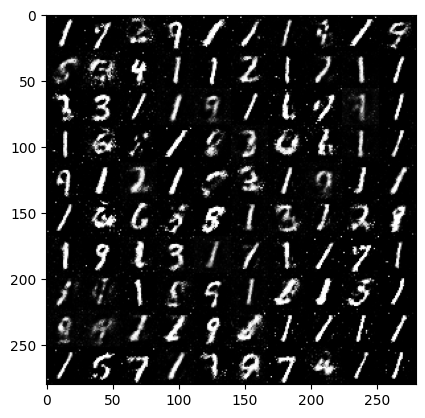

In [32]:
gan.g.eval()
with torch.no_grad():
    fake = gan.g().cpu()[:100]

x_pred = einops.rearrange(fake, '(img_h img_w) h w -> (img_h h) (img_w w)', img_h=10)
im = plt.imshow(x_pred, 'gray')
# plt.colorbar(im)
plt.show()

b. Report the Inception Score (https://github.com/openai/improved-gan/tree/master/inception_score).

In [ ]:
inception_score = InceptionScore()
inception_score.update(fake)
inception_score.compute()


c. Include Interpolations between two random latent variables. 
 


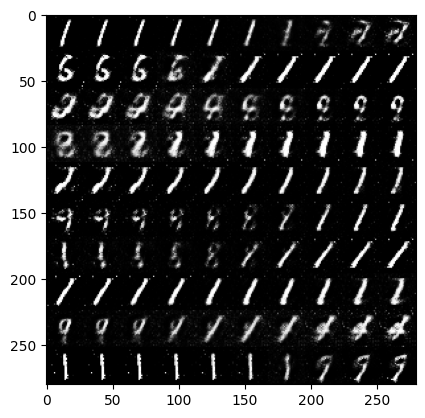

In [ ]:
latent = torch.empty((10, 10, gan.g.latent_dim)).to(DEVICE)
latent[0] = torch.normal(mean=torch.zeros((10, gan.g.latent_dim)), std=torch.ones((10, gan.g.latent_dim)))
latent[-1] = torch.normal(mean=torch.zeros((10, gan.g.latent_dim)), std=torch.ones((10, gan.g.latent_dim)))
for i in range(1,10):
    latent[i] = torch.lerp(latent[0], latent[-1], i * 0.1)
latent.reshape((100, gan.g.latent_dim))

gan.g.batch_size = 100

gan.g.eval()
with torch.no_grad():
    fake = gan.g(latent).cpu()

x_pred = einops.rearrange(fake, '(img_h img_w) h w -> (img_w h) (img_h w)', img_h=10)
im = plt.imshow(x_pred, 'gray')
# plt.colorbar(im)
plt.show()